#**Importing required libraries**

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
!pip install split-folders
import splitfolders as sf
import os

In [ ]:
import time
import torch
import copy
from PIL import Image
from torch import nn, optim
from torchvision import transforms

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import torchvision

#**Downloading inatuaralist dataset zip file from drive**

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id = '19EA0yl7PM8i6aQTdhH0OiEyLcTsf6hmx'

In [ ]:
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('nature_12K.zip')

#**Unzipping the content and distributing in train, validation and test folders**

In [ ]:
!apt install unzip

In [ ]:
!unzip 'nature_12K.zip'

In [ ]:
road='/content/inaturalist_12K/'
roadtrn=road+"train"
op= road+"trainvalsplit"
sf.fixed(roadtrn, op, seed=1337, fixed=100, oversample=False, group_prefix=None)

#**Preprocessing the images**

In [ ]:
#preprocessing train data
train_data = []
train_label = []
path = '/content/inaturalist_12K/trainvalsplit/train/'
items = os.listdir(path)
items.sort()

data_augmentation = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)


for i in range(10):
    image_folder_path = path + items[i]
    #print(image_folder_path)
    image_names = os.listdir(image_folder_path)
    for each_image in image_names:
        if each_image.endswith(".jpg"):
            full_path = image_folder_path + '/' + each_image
            image = Image.open(full_path)
            image = image.resize((224,224))
            if image.mode == 'L':
                continue
            normalized_image = data_augmentation(image)
            train_data.append((normalized_image, i))

In [ ]:
#preprocessing validation data
val_data = []
val_label = []
path = '/content/inaturalist_12K/trainvalsplit/val/'
items = os.listdir(path)
items.sort()

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

for i in range(10):
    image_folder_path = path + items[i]
    #print(image_folder_path)
    image_names = os.listdir(image_folder_path)
    for each_image in image_names:
        if each_image.endswith(".jpg"):
            full_path = image_folder_path + '/' + each_image
            image = Image.open(full_path)
            image = image.resize((224,224))
            if image.mode == 'L':
                continue
            normalized_image = transform(image)
            val_data.append((normalized_image, i))

In [ ]:
#preprocessing test data
test_data = []
test_label = []
path = '/content/inaturalist_12K/val/'
items = os.listdir(path)
items.sort()

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

for i in range(10):
    image_folder_path = path + items[i]
    #print(image_folder_path)
    image_names = os.listdir(image_folder_path)
    for each_image in image_names:
        if each_image.endswith(".jpg"):
            full_path = image_folder_path + '/' + each_image
            image = Image.open(full_path)
            image = image.resize((224,224))
            if image.mode == 'L':
                continue
            normalized_image = transform(image)
            test_data.append((normalized_image, i))

In [ ]:
classes = ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 
           'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#**Constructing Convolution Neural Network**

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, dropout, channels, activation, ks, fc_neurons):
        super(ConvNet, self).__init__()

        self.channels = channels
        if activation == 'ReLU':
          self.activation = nn.ReLU()
        elif activation == 'LeakyReLU':
          self.activation = nn.LeakyReLU()
        elif activation == 'ELU':
          self.activation = nn.ELU()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = channels[0], kernel_size = ks[0])
        torch.nn.init.xavier_normal_(self.conv1.weight)
        self.pool1 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        
        self.conv2 = nn.Conv2d(in_channels = channels[0], out_channels = channels[1], kernel_size = ks[1])
        torch.nn.init.xavier_normal_(self.conv2.weight)
        self.pool2 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        
        self.conv3 = nn.Conv2d(in_channels = channels[1], out_channels = channels[2], kernel_size = ks[2])
        torch.nn.init.xavier_normal_(self.conv3.weight)
        self.pool3 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        
        self.conv4 = nn.Conv2d(in_channels = channels[2], out_channels = channels[3], kernel_size = ks[3])
        torch.nn.init.xavier_normal_(self.conv4.weight)
        self.pool4 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        
        self.conv5 = nn.Conv2d(in_channels = channels[3], out_channels = channels[4], kernel_size = ks[4])
        torch.nn.init.xavier_normal_(self.conv5.weight)
        self.pool5 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(in_features = channels[4]*2*2, out_features = fc_neurons).to(device)
        torch.nn.init.xavier_normal_(self.fc.weight).to(device)        
        self.op = nn.Linear(in_features = fc_neurons, out_features = 10).to(device)

    def forward(self, x):
        x = self.pool1(self.activation(self.conv1(x)))
        x = self.pool2(self.activation(self.conv2(x)))
        x = self.pool3(self.activation(self.conv3(x)))
        x = self.pool4(self.activation(self.conv4(x)))
        x = self.pool5(self.activation(self.conv5(x)))
        
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = self.dropout(x)        
        x = self.activation(self.fc(x))
        x = self.op(x)
        
        return x

In [ ]:
#training fucntion for CNN
def train_model(model, criteria, optimizer, num_epochs=5, device='cuda'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(1, num_epochs+1):
        # print('Epoch {}/{}'.format(epoch, num_epochs ))
        # print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode                
            else:
                model.eval()   # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            if phase == 'train':
                f = train_loader                
            else:
                f = val_loader
            for inputs, labels in f:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criteria(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = 0
            epoch_acc = 0
            if phase == 'train':
                epoch_loss = running_loss / len(train_data)
                epoch_acc = running_corrects.double() /len(train_data)
            else:
                epoch_loss = running_loss / len(val_data)
                epoch_acc = running_corrects.double() / len(val_data)
            epoch_acc*=100
            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation acc: {:4f}'.format(best_acc))
   
    # load best model weights
    model.load_state_dict(best_model_wts)
    # return model

#**Defining data loaders and training the model**

In [ ]:
torch.manual_seed(50)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=200, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=100, shuffle=False)

#**Evaluating best model on test dataset**

In [ ]:
#Best model
model = ConvNet(0.25, [64*i for i in [1,2,4,8,16]], 'LeakyReLU', [5]*5, 512).to(device)
num_epochs = 10 
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, betas=(0.9, 0.999))
train_model(model, criteria, optimizer, num_epochs, 'cuda')

In [ ]:
# Calculating test accuracy
def evaluate():
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(10)]
        n_class_samples = [0 for i in range(10)]
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            
            for i in range(200):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1
            # break
        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc} %')

        for i in range(10):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {classes[i]}: {acc} %')

In [ ]:
evaluate()

#**Plotting grid for test data and its predictions**

In [ ]:
sample_images = []
sample_labels = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        pred = 0
        for count in range(30):            
            sample_images.append(images[count])
            sample_labels.append([labels[count], predicted[count]])
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

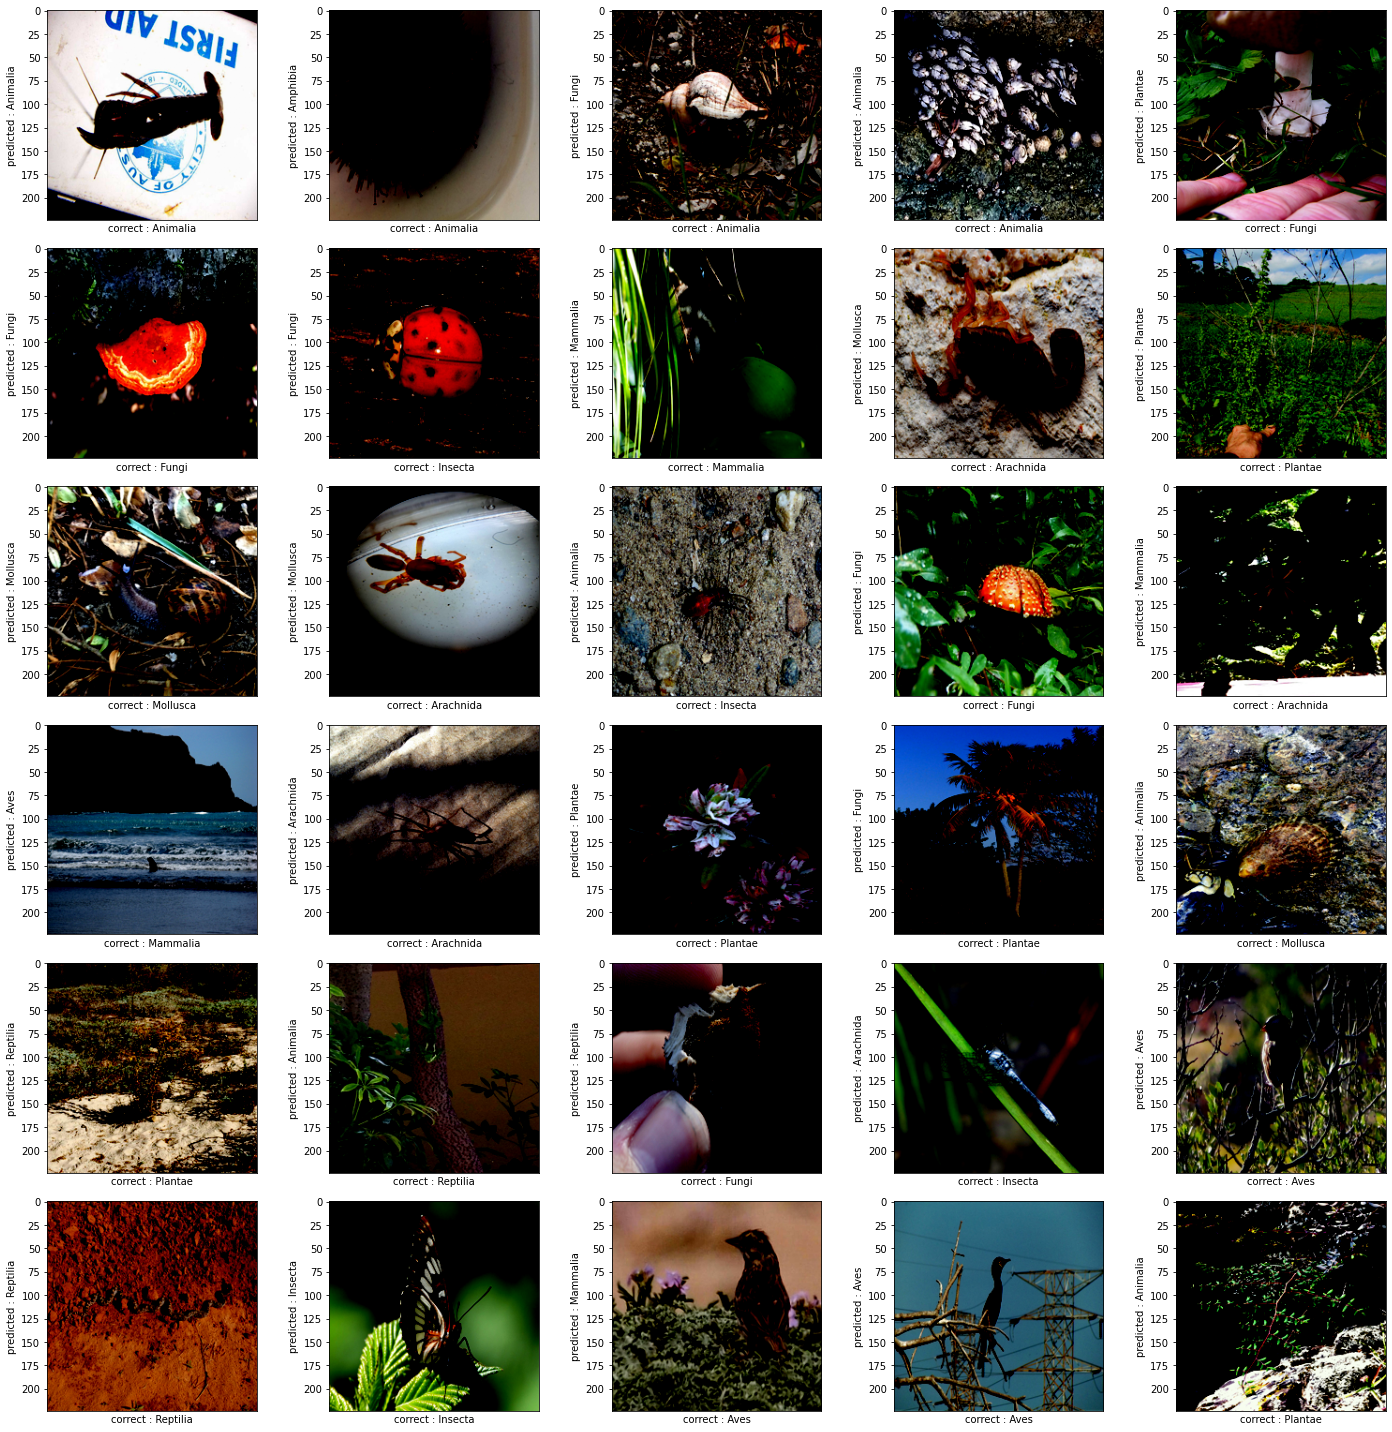

In [ ]:
xyz = plt.figure(figsize=(20,20))
for i in range(30):
    xyz.add_subplot(6, 5, i+1)
    npimg = sample_images[i].cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xlabel('correct : {}'.format(classes[sample_labels[i][0]]))
    plt.ylabel('predicted : {}'.format(classes[sample_labels[i][1]]))
    plt.xticks([])
    plt.grid(0)
xyz.tight_layout()

#**Visualizing all filters in first layer**

torch.Size([64, 3, 5, 5])


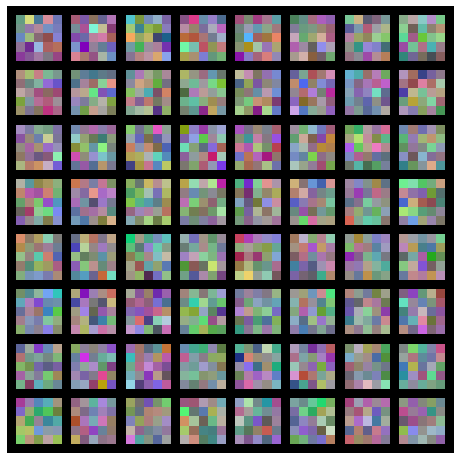

In [ ]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: 
        tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: 
        tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

filter = model.conv1.weight
print(filter.shape)
visTensor(filter.cpu(), ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()